# ML-7. ПРОГНОЗИРОВАНИЕ БИОЛОГИЧЕСКОГО ОТВЕТА (HW-3)

## 1.Задача 

* Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

## 2. Описание данных

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.
Предварительная обработка не требуется, данные уже закодированы и нормализованы.


## 3. Описание задачи

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

В качестве метрики будем использовать F1-score.

## 4. Импорт библиотек

In [1]:
import numpy as np #для матричных выражений
import pandas as pd #для обработки и анализа данных
import matplotlib.pyplot as plt #визуализация
import seaborn as sns #визуализация
import hyperopt #продвинутая оптимизация гиперпараметров модели
import optuna #продвинутая оптимизация гиперпараметров модели


from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка данных
from sklearn.model_selection import train_test_split #сплитирование данных
from sklearn.model_selection import GridSearchCV #оптимизация гиперпараметров модели
from sklearn.model_selection import RandomizedSearchCV #оптимизация гиперпараметров модели
from sklearn.model_selection import cross_val_score #кросс-валидация
from hyperopt import hp, fmin, tpe, Trials

%matplotlib inline
plt.style.use('seaborn')

/tmp/ipykernel_5014/1784025545.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# 5. Загрузка и подготовка данных

In [2]:
data = pd.read_csv('/home/tatiana/ML/Hiperparameters setting/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#проверка наличия пропусков
data.isnull().sum()

Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

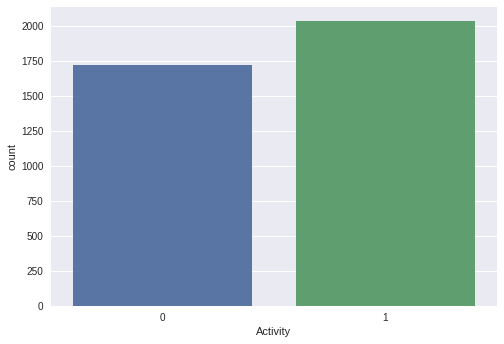

In [4]:
#проверка сбалансированности классов целевого признака
sns.countplot(data=data, x='Activity');

Вывод: Признак несбалансирован. Требуется стратифицированное разделение данных.

In [5]:
#Создаем матрицу наблюдений X и вектор ответов y
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [6]:
#Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [12]:
X_train.shape, X_test.shape

((3000, 1776), (751, 1776))

# 5. Оптимизация гиперпараметров модели

### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [7]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 50)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### **Случайный лес**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [8]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
# print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


Значение метрики для модели случайного леса лучше.  

Попробуем оптимизировать гиперпараметры моделей и сравним результаты.

### **GridSearchCV - Логистическая регрессия**

In [9]:
#указываем имена искомых гиперпараметров и их тестируемые значения в виде словаря

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
#передаем модель, словарь гиперпараметров, количество фолдов для кросс-валидации и указываем n_jobs=-1, чтобы использовать все ядра
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

CPU times: user 2.76 s, sys: 203 ms, total: 2.97 s
Wall time: 15.5 s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Значения метрики не изменились, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это не удивительно и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться.
Попробуем расширить сетку гиперпараметров.

In [10]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
grid_search_1.fit(X_train, y_train) 
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

CPU times: user 4.95 s, sys: 165 ms, total: 5.11 s
Wall time: 1min 40s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.76


In [12]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.453286,0.158629,0.059024,0.019423,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.793333,0.776667,0.736667,0.765,0.74,0.762333,0.021592,5
1,4.226830,0.317193,0.031626,0.002658,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.795000,0.776667,0.736667,0.765,0.74,0.762667,0.022076,4


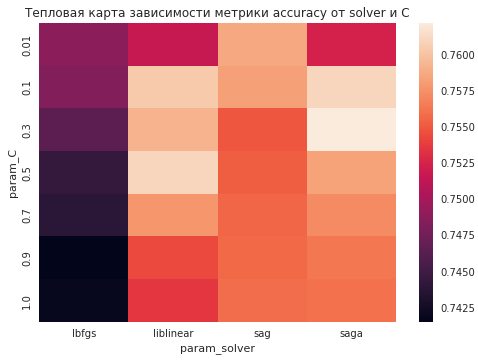

In [13]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что наилучший резултат дает алгоритм saga в сочетании с уровнем регуляризации 0,3

Метрика улучшилась незначительно, хотя время потратили гораздо больше.
Поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, а все потому что сетка значений конечна и наилучшее значение может оказаться между заданными нами значений.

### **GridSearchCV - Случайный лес**

In [18]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
            'min_samples_leaf': [5],
            'max_depth': list(np.linspace(20, 40, 5, dtype=int))
            }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: user 2.21 s, sys: 105 ms, total: 2.32 s
Wall time: 35.2 s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


Для случайного леса метрика осталась без изменений.

### **RandomizedSearchCV - Логистическая регрессия**

In [22]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_grid, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:35

CPU times: user 2.39 s, sys: 206 ms, total: 2.59 s
Wall time: 21.1 s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.01}


/home/tatiana/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### **RandomizedSearchCV - Случайных лес**

In [23]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 2.72 s, sys: 63.3 ms, total: 2.79 s
Wall time: 20.3 s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 22}


Выводы: 
1. Методами базовой оптимизации не удалось существенно улучшить метрику.
2. Наилучших результатов метрики удалось добиться применением модели Случайный лес (до и после применения методов базовой оптимизации).
3. RandomizedSearchCV дает лучшие результаты по затраченному времени чем GridSearchCV.

# Продвинутая оптимизация гиперпараметров модели

### **Hyperopt - Логистическая регрессия**

In [14]:
# проверим установленную версию Hyperopt
print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


In [31]:
# зададим пространство поиска гиперпараметров
# Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
space = {'penalty': hp.choice('penalty',['l2', 'none']) ,
    'solver': hp.choice('solver',['newton_cg', 'sag']),
    'C': hp.quniform('C',0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1)}    

In [32]:
# зафиксируем random_state
random_state = 42
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
             'C': params['min_samples_leaf']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(
        **params,
        random_state=random_state
    )

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [33]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))



  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]


TypeError: ap_quniform_sampler() got multiple values for argument 'size'

### **Hyperopt - Случайный лес**

In [34]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [35]:
%time # начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.seed(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 13.8 µs
100%|██████████| 20/20 [00:43<00:00,  2.18s/trial, best loss: -0.9901719901719903]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 2.0, 'n_estimators': 125.0}


In [36]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


С Hyperopt метрику улучшить не удалось.

### **Optuna - Случайный лес**

In [37]:
# Проверим версию 
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.0.0


In [38]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=random_state)
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

In [39]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2022-10-09 21:49:51,507] A new study created in memory with name: RandomForestClassifier
[I 2022-10-09 21:49:53,394] Trial 0 finished with value: 0.9564157269125266 and parameters: {'n_estimators': 118, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9564157269125266.
[I 2022-10-09 21:49:55,933] Trial 1 finished with value: 0.9740458015267175 and parameters: {'n_estimators': 157, 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9740458015267175.
[I 2022-10-09 21:49:57,502] Trial 2 finished with value: 0.9459541984732824 and parameters: {'n_estimators': 118, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9740458015267175.
[I 2022-10-09 21:49:58,959] Trial 3 finished with value: 0.9040097205346294 and parameters: {'n_estimators': 115, 'max_depth': 21, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9740458015267175.
[I 2022-10-09 21:50:00,888] Trial 4 finished with value: 0.9031866464339908 and parameters: {'n_

CPU times: user 2min 10s, sys: 1.18 s, total: 2min 11s
Wall time: 2min 11s


In [35]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 173, 'max_depth': 24, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [36]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.81


Метрику удалось улучшить методом  Optuna для модели Random Forest. Оптимальные параметры: n_estimators (количество деревьев) = 173, max_depth (максимальная глубина дерева) = 24, min_samples_leaf (минимальное количество объектов в листе) = 2. Значение метрики F1 = 0.81.